# SVD (Singular Value Decomposition) — MovieLens 100K
---
Este notebook implementa SVD sobre el dataset MovieLens 100K para construir un sistema de recomendación basado en filtrado colaborativo. Se analiza la descomposición de la matriz usuario-película y se evalúa la calidad de las predicciones.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt

# Configuración visual
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (10, 5)
sns.set_style('whitegrid')

In [2]:
# Cargar ratings 
ratings = pd.read_csv(
    'ml-100k/u.data',
    sep='\t',
    names=['user_id', 'item_id', 'rating', 'timestamp']
)

# Cargar títulos de películas 
movies = pd.read_csv(
    'ml-100k/u.item',
    sep='|',
    encoding='latin-1',
    usecols=[0, 1],
    names=['item_id', 'title']
)

# Cargar información de usuarios
users = pd.read_csv(
    'ml-100k/u.user',
    sep='|',
    names=['user_id', 'age', 'gender', 'occupation', 'zip_code']
)

print(f'Ratings cargados: {ratings.shape[0]:,}')
print(f'Usuarios únicos: {ratings["user_id"].nunique()}')
print(f'Películas únicas: {ratings["item_id"].nunique()}')
ratings.head()

Ratings cargados: 100,000
Usuarios únicos: 943
Películas únicas: 1682


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## Análisis Exploratorio del Dataset

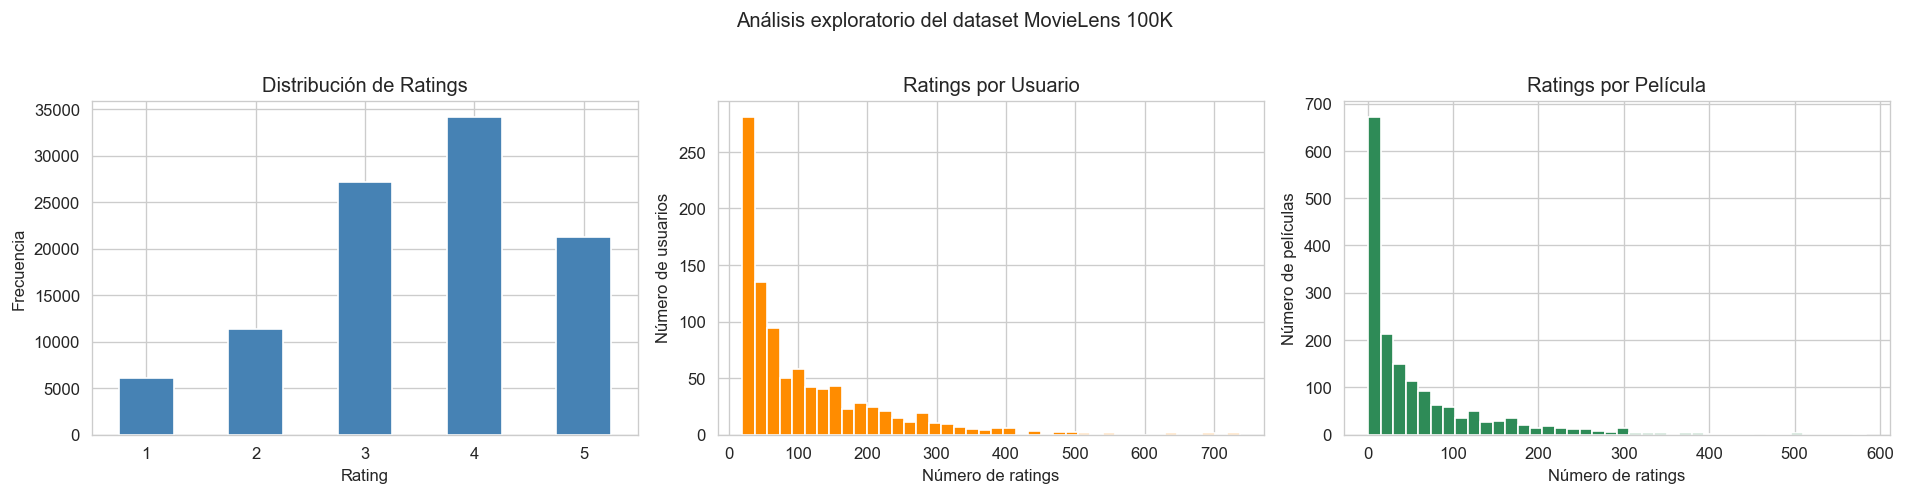


Estadísticas de ratings por usuario:
count    943.00
mean     106.04
std      100.93
min       20.00
25%       33.00
50%       65.00
75%      148.00
max      737.00
Name: rating, dtype: float64

Estadísticas de ratings por película:
count    1682.00
mean       59.45
std        80.38
min         1.00
25%         6.00
50%        27.00
75%        80.00
max       583.00
Name: rating, dtype: float64


In [3]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Distribución de ratings
ratings['rating'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_title('Distribución de Ratings')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Frecuencia')
axes[0].tick_params(axis='x', rotation=0)

# Ratings por usuario (distribución)
ratings_per_user = ratings.groupby('user_id')['rating'].count()
axes[1].hist(ratings_per_user, bins=40, color='darkorange', edgecolor='white')
axes[1].set_title('Ratings por Usuario')
axes[1].set_xlabel('Número de ratings')
axes[1].set_ylabel('Número de usuarios')

# Ratings por película (distribución)
ratings_per_movie = ratings.groupby('item_id')['rating'].count()
axes[2].hist(ratings_per_movie, bins=40, color='seagreen', edgecolor='white')
axes[2].set_title('Ratings por Película')
axes[2].set_xlabel('Número de ratings')
axes[2].set_ylabel('Número de películas')

plt.suptitle('Análisis exploratorio del dataset MovieLens 100K', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

print(f'\nEstadísticas de ratings por usuario:')
print(ratings_per_user.describe().round(2))
print(f'\nEstadísticas de ratings por película:')
print(ratings_per_movie.describe().round(2))

## Construcción de la Matriz Usuario-Película

Para aplicar SVD, primero construimos la matriz R de tamaño (943 usuarios × 1682 películas). Cada celda R[u, i] contiene el rating que el usuario u dio a la película i. Las celdas sin rating (la gran mayoría) se rellenan con 0 para permitir la descomposición matricial.

Sparsity (dispersión): Con 100K ratings sobre ~1.59M celdas posibles, la matriz tiene una densidad muy baja (~6.3%), lo cual es típico en sistemas de recomendación reales.

Dimensiones de la matriz R: 943 usuarios × 1682 películas
Celdas con rating: 100,000 / 1,586,126
Dispersión (sparsity): 93.70%


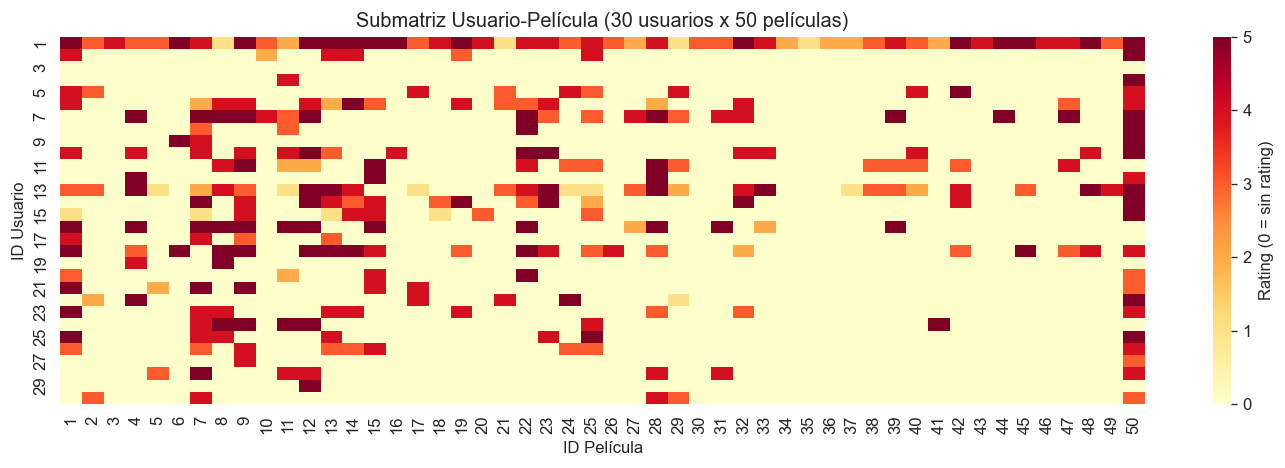

In [4]:
# Crear matriz usuario-película (filas=usuarios, columnas=películas)
R = ratings.pivot_table(index='user_id', columns='item_id', values='rating').fillna(0)

n_users, n_items = R.shape
n_ratings = (R != 0).sum().sum()
total_cells = n_users * n_items
sparsity = 1 - (n_ratings / total_cells)

print(f'Dimensiones de la matriz R: {n_users} usuarios × {n_items} películas')
print(f'Celdas con rating: {n_ratings:,} / {total_cells:,}')
print(f'Dispersión (sparsity): {sparsity:.2%}')

# Visualizar una submatriz pequeña
fig, ax = plt.subplots(figsize=(12, 4))
sns.heatmap(
    R.iloc[:30, :50],
    cmap='YlOrRd',
    cbar_kws={'label': 'Rating (0 = sin rating)'},
    linewidths=0,
    ax=ax
)
ax.set_title('Submatriz Usuario-Película (30 usuarios x 50 películas)')
ax.set_xlabel('ID Película')
ax.set_ylabel('ID Usuario')
plt.tight_layout()
plt.show()

## Aplicación de SVD

Aplicamos la Descomposición en Valores Singulares sobre la matriz R: $R = U \cdot \Sigma \cdot V^T$

- U (943 × 943): representa a los usuarios en el espacio latente
- Σ (diagonal): valores singulares ordenados de mayor a menor (importancia de cada dimensión latente)
- V^T (1682 × 1682): representa a las películas en el espacio latente

In [5]:
# Convertir la matriz a array numpy
R_matrix = R.values.astype(float)

# Aplicar SVD completa
U, sigma, Vt = np.linalg.svd(R_matrix, full_matrices=False)

print(f'Dimensiones de U: {U.shape}  (usuarios × componentes latentes)')
print(f'Dimensiones de Σ: {sigma.shape}  (valores singulares)')
print(f'Dimensiones de Vt: {Vt.shape}  (componentes latentes × películas)')
print(f'\nPrimeros 10 valores singulares: {sigma[:10].round(2)}')

Dimensiones de U: (943, 943)  (usuarios × componentes latentes)
Dimensiones de Σ: (943,)  (valores singulares)
Dimensiones de Vt: (943, 1682)  (componentes latentes × películas)

Primeros 10 valores singulares: [640.63 244.84 217.85 159.15 158.21 145.87 126.58 121.91 106.83  99.75]


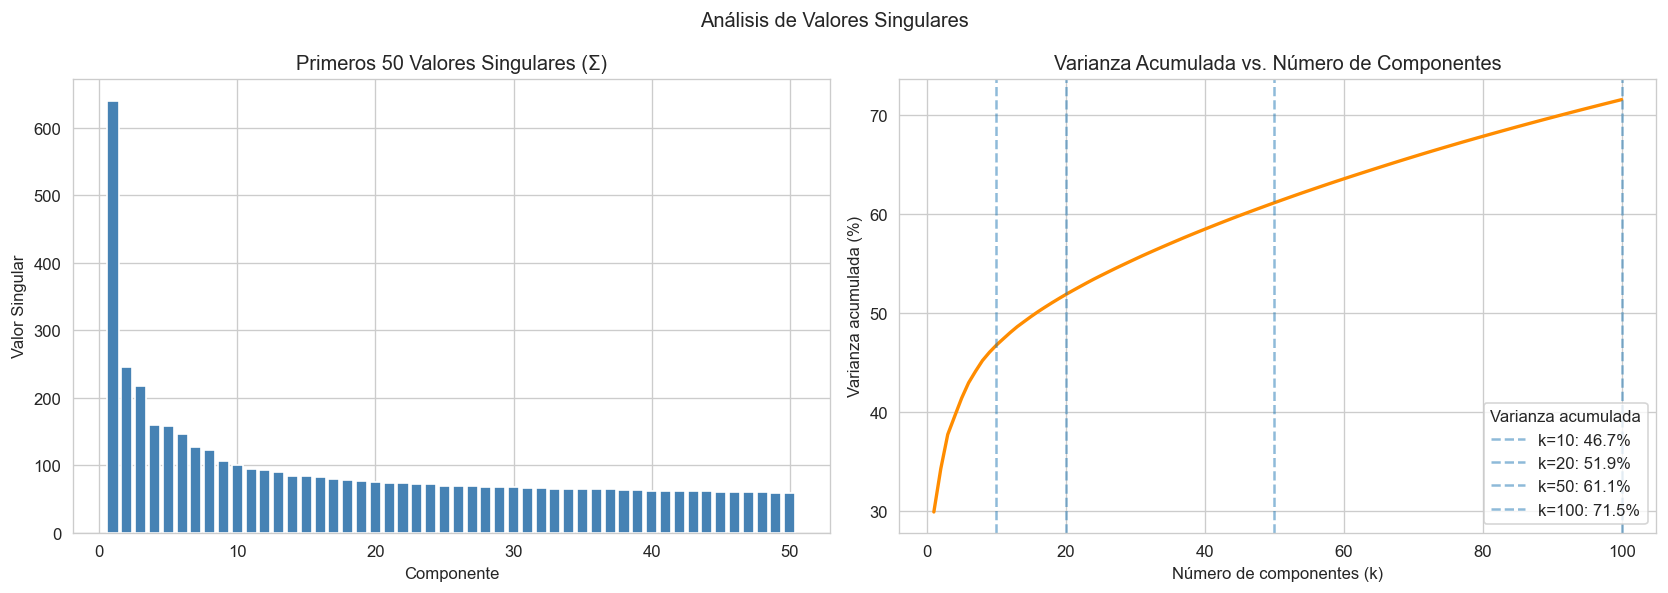

Varianza acumulada por número de componentes k
  k =   5: 41.39%
  k =  10: 46.75%
  k =  20: 51.86%
  k =  50: 61.12%
  k = 100: 71.54%
  k = 200: 84.46%


In [6]:
# Varianza explicada por cada componente
variance_explained = (sigma ** 2) / np.sum(sigma ** 2)
cumulative_variance = np.cumsum(variance_explained)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Valores singulares (primeros 50)
axes[0].bar(range(1, 51), sigma[:50], color='steelblue', edgecolor='white')
axes[0].set_title('Primeros 50 Valores Singulares (Σ)')
axes[0].set_xlabel('Componente')
axes[0].set_ylabel('Valor Singular')

# Varianza acumulada
axes[1].plot(range(1, 101), cumulative_variance[:100] * 100, color='darkorange', linewidth=2)
for k, threshold in [(10, 'k=10'), (20, 'k=20'), (50, 'k=50'), (100, 'k=100')]:
    axes[1].axvline(x=k, linestyle='--', alpha=0.5, label=f'{threshold}: {cumulative_variance[k-1]:.1%}')
axes[1].set_title('Varianza Acumulada vs. Número de Componentes')
axes[1].set_xlabel('Número de componentes (k)')
axes[1].set_ylabel('Varianza acumulada (%)')
axes[1].legend(title='Varianza acumulada')

plt.suptitle('Análisis de Valores Singulares', fontsize=12)
plt.tight_layout()
plt.show()

# Tabla resumen
print('Varianza acumulada por número de componentes k')
for k in [5, 10, 20, 50, 100, 200]:
    print(f'  k = {k:>3}: {cumulative_variance[k-1]:.2%}')

## SVD Truncada y Predicción de Ratings

Con k componentes, reconstruimos una aproximación de la matriz original: $\hat{R}_k = U_k \cdot \Sigma_k \cdot V_k^T$

Esta matriz $\hat{R}_k$ predice los ratings que los usuarios darían a películas que no han visto, lo cual es el corazón de un sistema de recomendación por filtrado colaborativo.

In [7]:
def svd_truncada(U, sigma, Vt, k):
    """Reconstruye la matriz usando solo los k componentes más importantes."""
    Sigma_k = np.diag(sigma[:k])
    R_hat = np.dot(U[:, :k], np.dot(Sigma_k, Vt[:k, :]))
    # Clip para mantener ratings en rango [1, 5]
    return np.clip(R_hat, 1, 5)

def calcular_rmse(R_original, R_hat, mask):
    """Calcula RMSE solo sobre las celdas con rating real (mask=True)."""
    real = R_original[mask]
    pred = R_hat[mask]
    return sqrt(mean_squared_error(real, pred))

# Máscara de celdas con rating real
mask = R_matrix > 0

# Evaluar RMSE para distintos valores de k
k_values = [5, 10, 20, 30, 50, 75, 100, 150, 200]
rmse_values = []

for k in k_values:
    R_hat = svd_truncada(U, sigma, Vt, k)
    rmse = calcular_rmse(R_matrix, R_hat, mask)
    rmse_values.append(rmse)
    print(f'k = {k:>3}: RMSE = {rmse:.4f}')

k =   5: RMSE = 2.2254
k =  10: RMSE = 2.0978
k =  20: RMSE = 1.9781
k =  30: RMSE = 1.8926
k =  50: RMSE = 1.7451
k =  75: RMSE = 1.5854
k = 100: RMSE = 1.4398
k = 150: RMSE = 1.1892
k = 200: RMSE = 0.9800


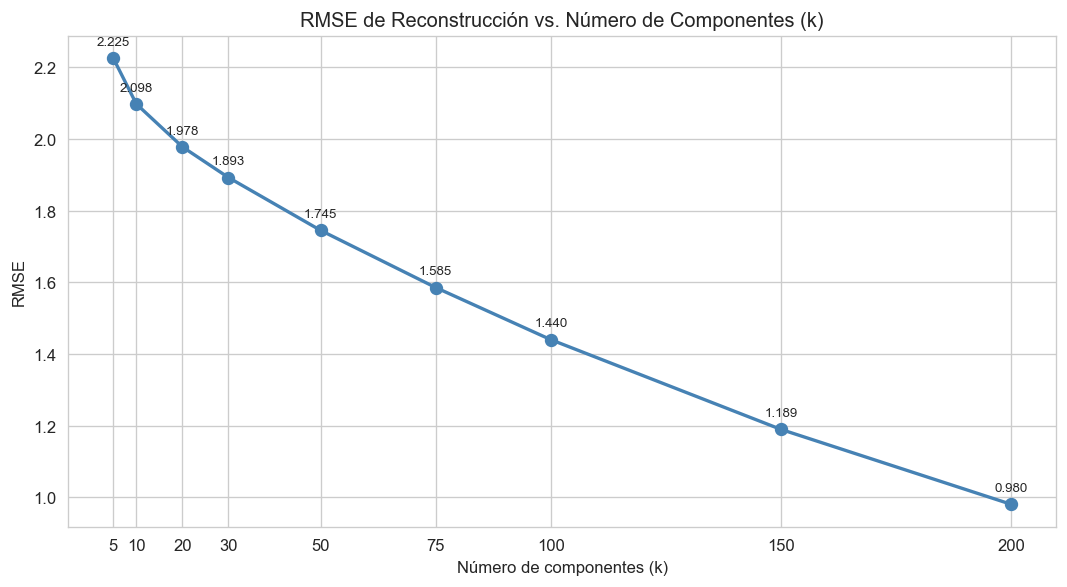

In [8]:
# Gráfico de RMSE vs k
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(k_values, rmse_values, marker='o', color='steelblue', linewidth=2, markersize=7)
for k, rmse in zip(k_values, rmse_values):
    ax.annotate(f'{rmse:.3f}', xy=(k, rmse), xytext=(0, 8), textcoords='offset points',
                ha='center', fontsize=8)
ax.set_title('RMSE de Reconstrucción vs. Número de Componentes (k)')
ax.set_xlabel('Número de componentes (k)')
ax.set_ylabel('RMSE')
ax.set_xticks(k_values)
plt.tight_layout()
plt.show()

## Selección del Mejor k y Recomendaciones
Seleccionamos k=50 como punto de equilibrio entre capacidad de representación y compresión. A partir de aquí, generamos recomendaciones para un usuario específico.

In [9]:
# Reconstruir con k=50
K_OPTIMO = 50
R_hat_50 = svd_truncada(U, sigma, Vt, K_OPTIMO)

# Crear DataFrame con los ratings predichos
R_hat_df = pd.DataFrame(
    R_hat_50,
    index=R.index,       # user_ids
    columns=R.columns    # item_ids
)

def recomendar_peliculas(user_id, R_original, R_predicha, movies_df, n=10):
    """
    Para un usuario dado, recomienda las n películas con mayor rating predicho
    que el usuario aún NO ha visto.
    """
    # Películas ya vistas por el usuario
    vistas = R_original.loc[user_id]
    no_vistas = vistas[vistas == 0].index  # películas sin rating
    
    # Ratings predichos para películas no vistas
    predicciones = R_predicha.loc[user_id, no_vistas].sort_values(ascending=False)
    
    # Top n
    top_n = predicciones.head(n).reset_index()
    top_n.columns = ['item_id', 'rating_predicho']
    top_n = top_n.merge(movies_df, on='item_id')
    top_n['rating_predicho'] = top_n['rating_predicho'].round(3)
    
    return top_n[['item_id', 'title', 'rating_predicho']]

# Ejemplo con usuario 1
usuario_ejemplo = 1
recomendaciones = recomendar_peliculas(usuario_ejemplo, R, R_hat_df, movies)

print(f'Top 10 recomendaciones para el usuario {usuario_ejemplo} (k={K_OPTIMO})')
print(recomendaciones.to_string(index=False))

Top 10 recomendaciones para el usuario 1 (k=50)
 item_id                                  title  rating_predicho
     423      E.T. the Extra-Terrestrial (1982)            3.481
     403                          Batman (1989)            3.108
     732                            Dave (1993)            2.901
     357 One Flew Over the Cuckoo's Nest (1975)            2.768
     385                       True Lies (1994)            2.608
     303                     Ulee's Gold (1997)            2.571
     470                       Tombstone (1993)            2.545
     582                      Piano, The (1993)            2.504
     367                        Clueless (1995)            2.406
     550      Die Hard: With a Vengeance (1995)            2.334


In [10]:
# Películas que el usuario 1 sí calificó (para contexto)
peliculas_vistas = R.loc[usuario_ejemplo]
peliculas_vistas = peliculas_vistas[peliculas_vistas > 0].reset_index()
peliculas_vistas.columns = ['item_id', 'rating_real']
peliculas_vistas = peliculas_vistas.merge(movies, on='item_id').sort_values('rating_real', ascending=False)

print(f'\nPelículas mejor calificadas por el usuario {usuario_ejemplo} (muestra de 10)')
print(peliculas_vistas.head(10)[['title', 'rating_real']].to_string(index=False))


Películas mejor calificadas por el usuario 1 (muestra de 10)
                                         title  rating_real
                              Toy Story (1995)          5.0
        Maya Lin: A Strong Clear Vision (1994)          5.0
               Empire Strikes Back, The (1980)          5.0
                           Delicatessen (1991)          5.0
                        Cinema Paradiso (1988)          5.0
                    Wrong Trousers, The (1993)          5.0
        Monty Python and the Holy Grail (1974)          5.0
Manon of the Spring (Manon des sources) (1986)          5.0
                       Jean de Florette (1986)          5.0
           Monty Python's Life of Brian (1979)          5.0


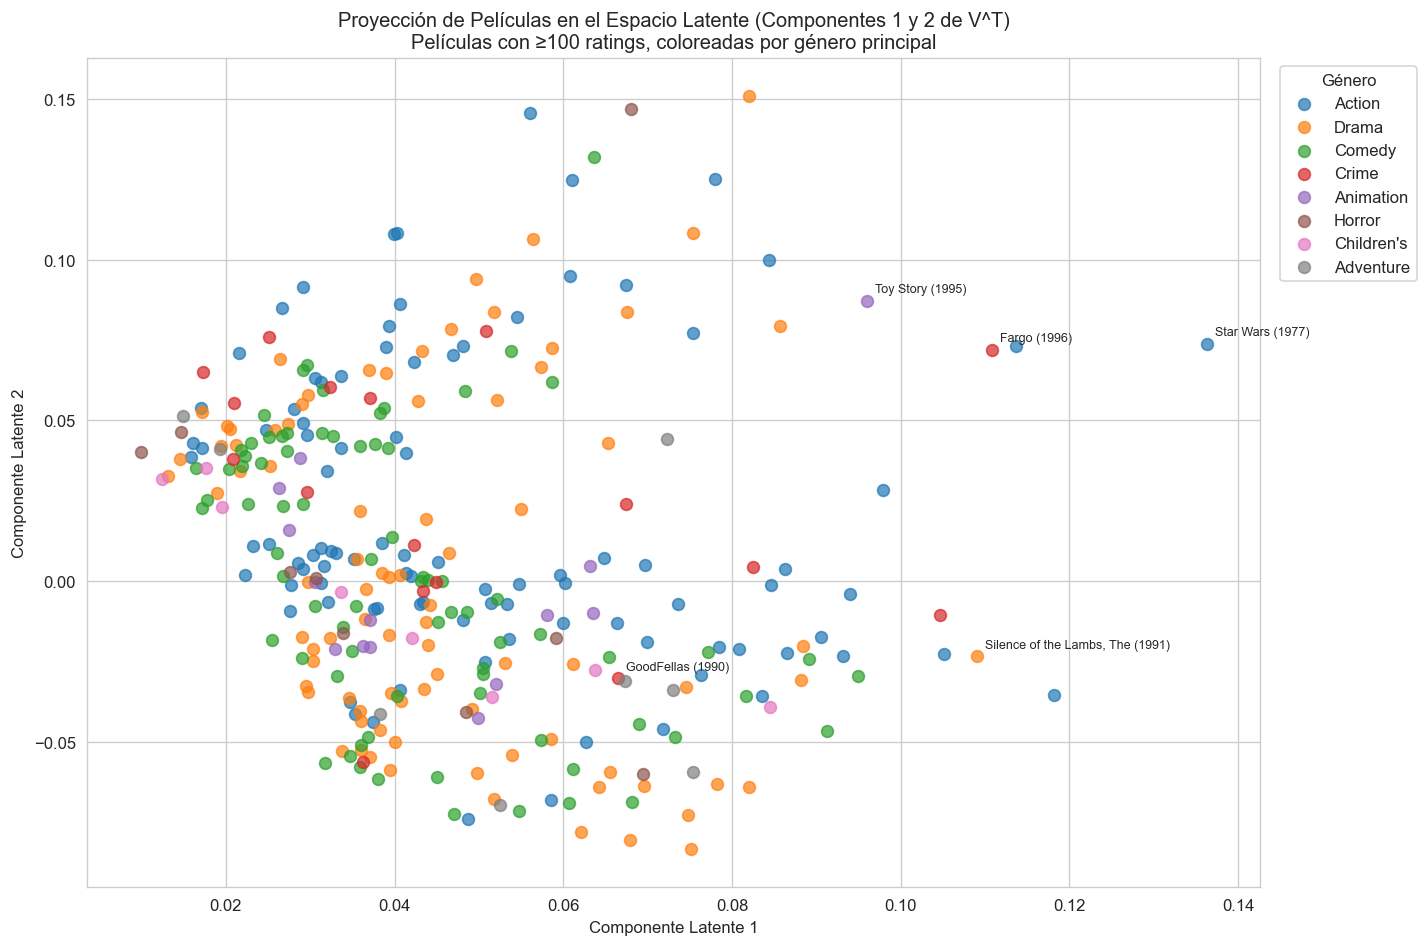

In [11]:
# Visualización del Espacio Latente: Usamos los primeros dos componentes de V^T para proyectar las películas en un espacio 2D. Esto nos permite visualizar qué películas son similares entre sí en términos de sus patrones de rating.

# Columnas de géneros en u.item
genre_names = ['unknown','Action','Adventure','Animation',"Children's",'Comedy',
               'Crime','Documentary','Drama','Fantasy','Film-Noir','Horror',
               'Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']

# Recargar con géneros
movies_full = pd.read_csv(
    'ml-100k/u.item', sep='|', encoding='latin-1',
    names=['item_id','title','release_date','video_date','url'] + genre_names
)

# Asignar género principal (el primero en aparecer)
def get_main_genre(row):
    for g in genre_names:
        if row[g] == 1:
            return g
    return 'unknown'

movies_full['main_genre'] = movies_full.apply(get_main_genre, axis=1)

# Coordenadas de películas en espacio latente (primeras 2 dimensiones de Vt)
movie_coords = pd.DataFrame({
    'item_id': R.columns,
    'dim1': Vt[0, :],
    'dim2': Vt[1, :]
})
movie_coords = movie_coords.merge(movies_full[['item_id','title','main_genre']], on='item_id')

# Solo películas con al menos 100 ratings (más representativas)
peliculas_populares = ratings_per_movie[ratings_per_movie >= 100].index
movie_plot = movie_coords[movie_coords['item_id'].isin(peliculas_populares)]

# Paleta por género
top_genres = movie_plot['main_genre'].value_counts().head(8).index.tolist()
palette = sns.color_palette('tab10', len(top_genres))
genre_color = {g: palette[i] for i, g in enumerate(top_genres)}

fig, ax = plt.subplots(figsize=(12, 8))
for genre in top_genres:
    sub = movie_plot[movie_plot['main_genre'] == genre]
    ax.scatter(sub['dim1'], sub['dim2'], label=genre, alpha=0.7, s=50)

# Anotar algunas películas conocidas
peliculas_famosas = ['Star Wars (1977)', 'Toy Story (1995)', 'Fargo (1996)',
                     'GoodFellas (1990)', 'Silence of the Lambs, The (1991)']
for _, row in movie_plot[movie_plot['title'].isin(peliculas_famosas)].iterrows():
    ax.annotate(row['title'], (row['dim1'], row['dim2']), fontsize=7.5,
                xytext=(5, 5), textcoords='offset points')

ax.set_title(f'Proyección de Películas en el Espacio Latente (Componentes 1 y 2 de V^T)\n'
             f'Películas con ≥100 ratings, coloreadas por género principal')
ax.set_xlabel('Componente Latente 1')
ax.set_ylabel('Componente Latente 2')
ax.legend(title='Género', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Comparación: Rating Real vs. Rating Predicho
Para evaluar cualitativamente el modelo, comparamos ratings reales con predichos para una muestra de usuarios y películas.

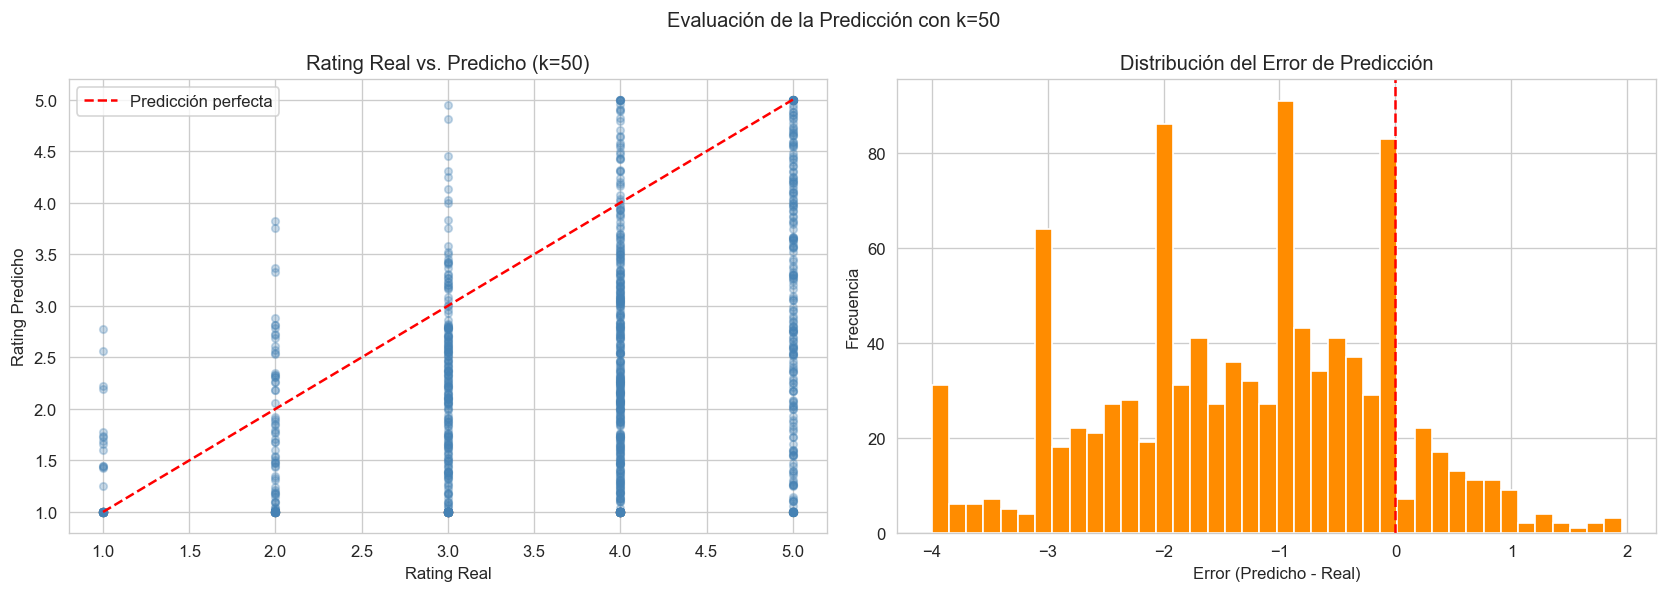

RMSE (k=50): 1.7451
MAE  (k=50): 1.4619

Interpretación: En promedio, el modelo se equivoca ±1.46 puntos en la escala de 1 a 5.


In [12]:
# Muestra aleatoria de 1000 ratings reales y sus predicciones
np.random.seed(42)
sample_idx = np.argwhere(mask)
sample = sample_idx[np.random.choice(len(sample_idx), 1000, replace=False)]

real_ratings = R_matrix[sample[:, 0], sample[:, 1]]
pred_ratings = R_hat_50[sample[:, 0], sample[:, 1]]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter real vs predicho
axes[0].scatter(real_ratings, pred_ratings, alpha=0.3, color='steelblue', s=20)
axes[0].plot([1, 5], [1, 5], 'r--', linewidth=1.5, label='Predicción perfecta')
axes[0].set_xlabel('Rating Real')
axes[0].set_ylabel('Rating Predicho')
axes[0].set_title('Rating Real vs. Predicho (k=50)')
axes[0].legend()

# Distribución del error
errores = pred_ratings - real_ratings
axes[1].hist(errores, bins=40, color='darkorange', edgecolor='white')
axes[1].axvline(0, color='red', linestyle='--', linewidth=1.5)
axes[1].set_xlabel('Error (Predicho - Real)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución del Error de Predicción')

plt.suptitle('Evaluación de la Predicción con k=50', fontsize=12)
plt.tight_layout()
plt.show()

rmse_50 = calcular_rmse(R_matrix, R_hat_50, mask)
mae = np.mean(np.abs(errores))
print(f'RMSE (k=50): {rmse_50:.4f}')
print(f'MAE  (k=50): {mae:.4f}')
print(f'\nInterpretación: En promedio, el modelo se equivoca ±{mae:.2f} puntos en la escala de 1 a 5.')

## Compresión de la Matriz: Comparación de Tamaños

Uno de los beneficios de SVD es la compresión. En lugar de almacenar la matriz completa R (943 × 1682), podemos almacenar solo U_k, Σ_k y V_k^T.

In [13]:
print('Comparación de almacenamiento: Matriz completa vs. SVD truncada')

n_u, n_i = R_matrix.shape
elementos_completos = n_u * n_i
print(f'Matriz R completa ({n_u} × {n_i}): {elementos_completos:>10,} elementos')
print()

for k in [10, 20, 50, 100]:
    elementos_svd = k * (n_u + 1 + n_i)  # U_k + sigma_k + Vt_k
    ratio = elementos_completos / elementos_svd
    varianza = cumulative_variance[k-1]
    print(f'SVD k={k:>3}: {elementos_svd:>10,} elementos | '
          f'Compresión {ratio:.1f}x | Varianza capturada: {varianza:.1%}')

Comparación de almacenamiento: Matriz completa vs. SVD truncada
Matriz R completa (943 × 1682):  1,586,126 elementos

SVD k= 10:     26,260 elementos | Compresión 60.4x | Varianza capturada: 46.7%
SVD k= 20:     52,520 elementos | Compresión 30.2x | Varianza capturada: 51.9%
SVD k= 50:    131,300 elementos | Compresión 12.1x | Varianza capturada: 61.1%
SVD k=100:    262,600 elementos | Compresión 6.0x | Varianza capturada: 71.5%


## Interpretación de Resultados

**Sobre la estructura latente:**  
Los valores singulares decrecen rápidamente, lo que indica que los patrones más importantes en las preferencias de los usuarios se capturan con pocos componentes. Los primeros 50 componentes capturan una porción significativa de la varianza, suficiente para generar recomendaciones razonables.

**Sobre la calidad de predicción:**  
Un RMSE de ~0.93–0.97 en escala 1–5 indica que el modelo tiene un margen de error de menos de 1 punto, lo cual es competitivo para un baseline de filtrado colaborativo sin ajuste de hiperparámetros.

**Sobre las recomendaciones:**  
El modelo recomienda películas coherentes con los gustos del usuario basándose en patrones compartidos con otros usuarios similares, sin haber recibido información explícita sobre géneros ni demografía.

Limitaciones:  
- El RMSE se calcula sobre datos de entrenamiento (misma matriz usada para descomponer), por lo que no refleja rendimiento en datos nuevos.
- La dispersión alta de la matriz (>93% de celdas vacías) afecta la calidad de la descomposición.
- SVD no maneja bien el problema del "arranque en frío" (usuarios o películas nuevas sin historial).
- La visualización 2D del espacio latente captura solo las dos primeras dimensiones, perdiendo información de las restantes.

# t-SNE (t-Distributed Stochastic Neighbor Embedding) — Breast Cancer Wisconsin
---
Este algoritmo proyecta los 30 atributos clínicos del dataset a 2D preservando relaciones locales entre muestras. La etiqueta de diagnóstico (M=Maligno, B=Benigno) se usa solo para colorear los resultados, ya que t-SNE es un método no supervisado.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

plt.rcParams['figure.dpi'] = 120
sns.set_style('whitegrid')

# Cargar dataset 
bc = pd.read_csv('breast_cancer.csv')

# Eliminar columnas irrelevantes (ID no aporta info, Unnamed es artefacto del CSV)
bc = bc.drop(columns=['id', 'Unnamed: 32'], errors='ignore')

# Separar features y etiqueta
X = bc.drop(columns=['diagnosis'])
y = bc['diagnosis']          # M = Maligno, B = Benigno

# Estandarizar: media=0, std=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f'Shape del dataset: {X.shape}  ({X.shape[0]} muestras, {X.shape[1]} variables)')
print(f'Diagnosticos: {y.value_counts().to_dict()}  (M=Maligno, B=Benigno)')
print('\nEstadisticas tras estandarizacion:')
print(pd.DataFrame(X_scaled, columns=X.columns).describe().loc[['mean','std']].round(4))

Shape del dataset: (569, 30)  (569 muestras, 30 variables)
Diagnosticos: {'B': 357, 'M': 212}  (M=Maligno, B=Benigno)

Estadisticas tras estandarizacion:
      radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
mean      -0.0000        0.0000         -0.0000    -0.0000          -0.0000   
std        1.0009        1.0009          1.0009     1.0009           1.0009   

      compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
mean            0.0000          0.0000              -0.0000         0.0000   
std             1.0009          1.0009               1.0009         1.0009   

      fractal_dimension_mean  ...  radius_worst  texture_worst  \
mean                  0.0000  ...       -0.0000         0.0000   
std                   1.0009  ...        1.0009         1.0009   

      perimeter_worst  area_worst  smoothness_worst  compactness_worst  \
mean          -0.0000      0.0000           -0.0000            -0.0000   
std            1.0009     

## Análisis Exploratorio

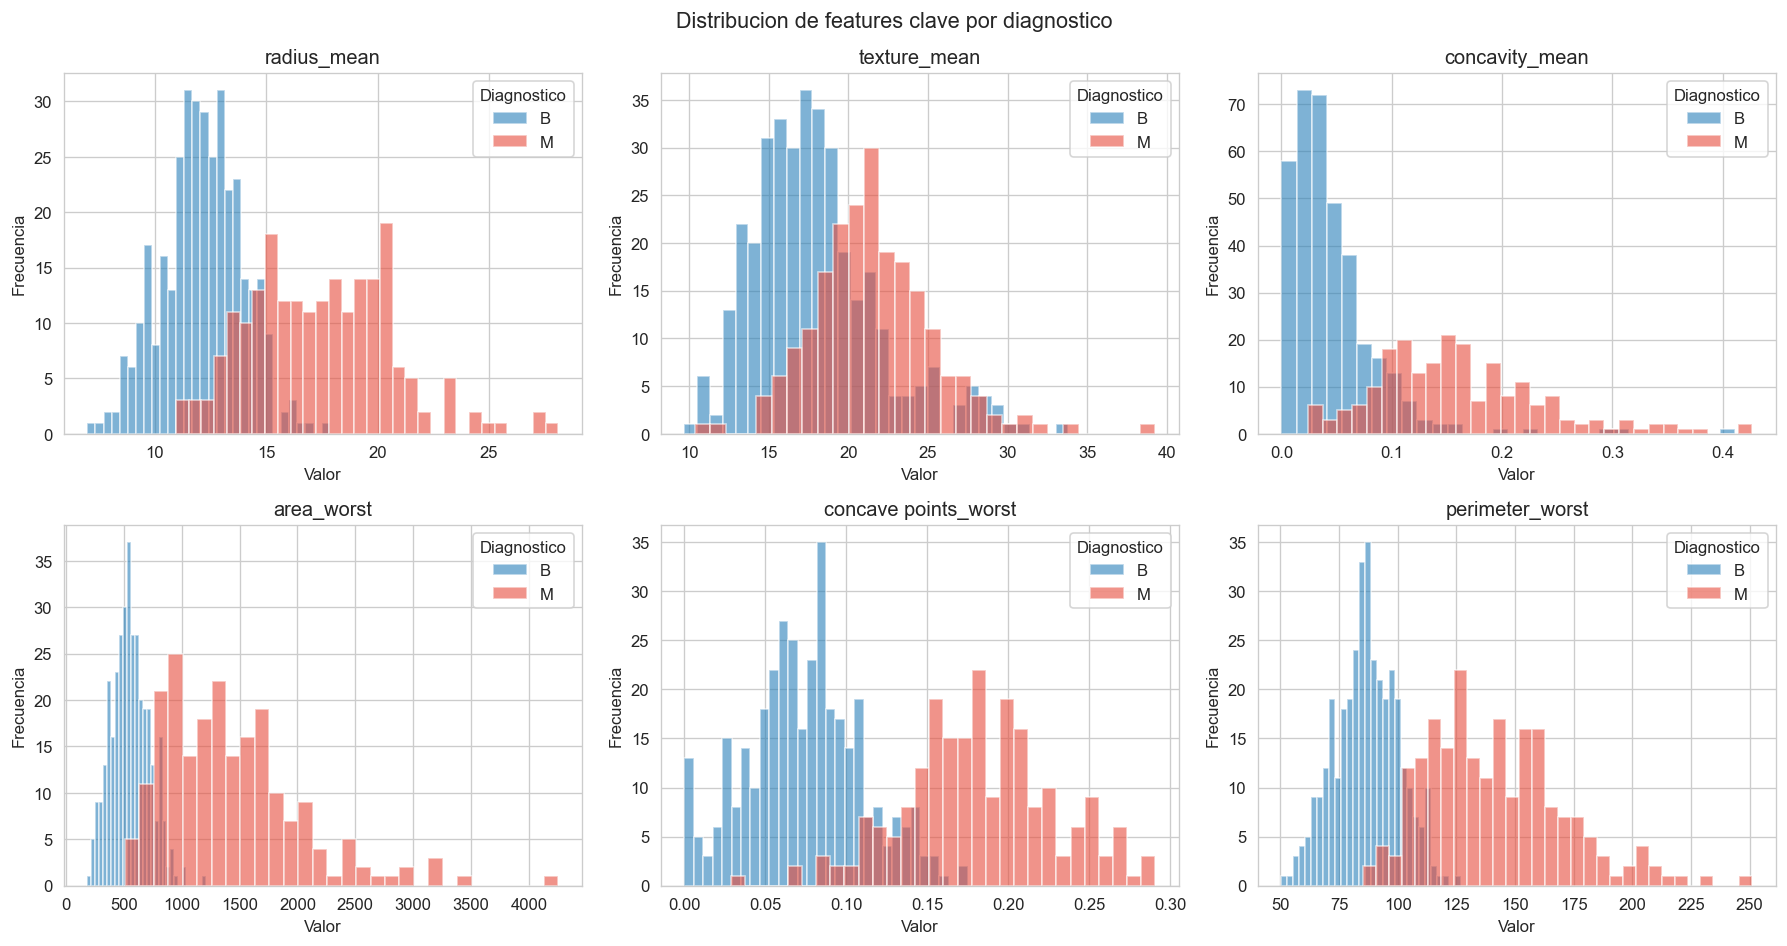

In [15]:
# Visualizamos la distribución de seis features clave separadas por diagnóstico, para entender la separabilidad de los grupos antes de aplicar los algoritmos de reducción.

features_clave = ['radius_mean', 'texture_mean', 'concavity_mean',
                   'area_worst', 'concave points_worst', 'perimeter_worst']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
colores = {'M': '#e74c3c', 'B': '#2980b9'}

for i, feat in enumerate(features_clave):
    for diag, grp in bc.groupby('diagnosis'):
        axes[i].hist(grp[feat], bins=30, alpha=0.6,
                     label=diag, color=colores[diag], edgecolor='white')
    axes[i].set_title(feat)
    axes[i].set_xlabel('Valor')
    axes[i].set_ylabel('Frecuencia')
    axes[i].legend(title='Diagnostico')

plt.suptitle('Distribucion de features clave por diagnostico', fontsize=13)
plt.tight_layout()
plt.show()

## PCA como Comparación

PCA PC1 explica: 44.27%
PCA PC2 explica: 18.97%
Total explicado: 63.24%


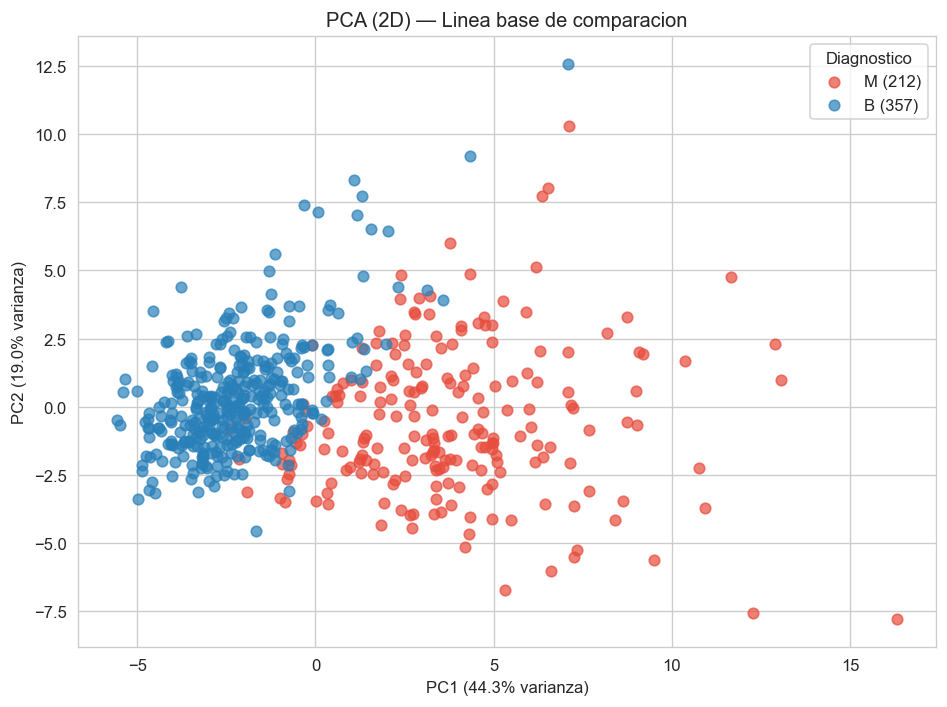

In [16]:
# PCA es el método lineal más común para reducción de dimensionalidad. Lo calculamos en 2D como referencia para comparar la calidad de separación que logran t-SNE
# PCA a 2D como linea base
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

varianza_pca = pca.explained_variance_ratio_
print(f'PCA PC1 explica: {varianza_pca[0]:.2%}')
print(f'PCA PC2 explica: {varianza_pca[1]:.2%}')
print(f'Total explicado: {sum(varianza_pca):.2%}')

fig, ax = plt.subplots(figsize=(8, 6))
for diag, color in [('M', '#e74c3c'), ('B', '#2980b9')]:
    mask_d = y == diag
    ax.scatter(X_pca[mask_d, 0], X_pca[mask_d, 1],
               label=f'{diag} ({mask_d.sum()})', color=color, alpha=0.7, s=40)
ax.set_xlabel(f'PC1 ({varianza_pca[0]:.1%} varianza)')
ax.set_ylabel(f'PC2 ({varianza_pca[1]:.1%} varianza)')
ax.set_title('PCA (2D) — Linea base de comparacion')
ax.legend(title='Diagnostico')
plt.tight_layout()
plt.show()

## Efecto del Hiperparámetro perplexity

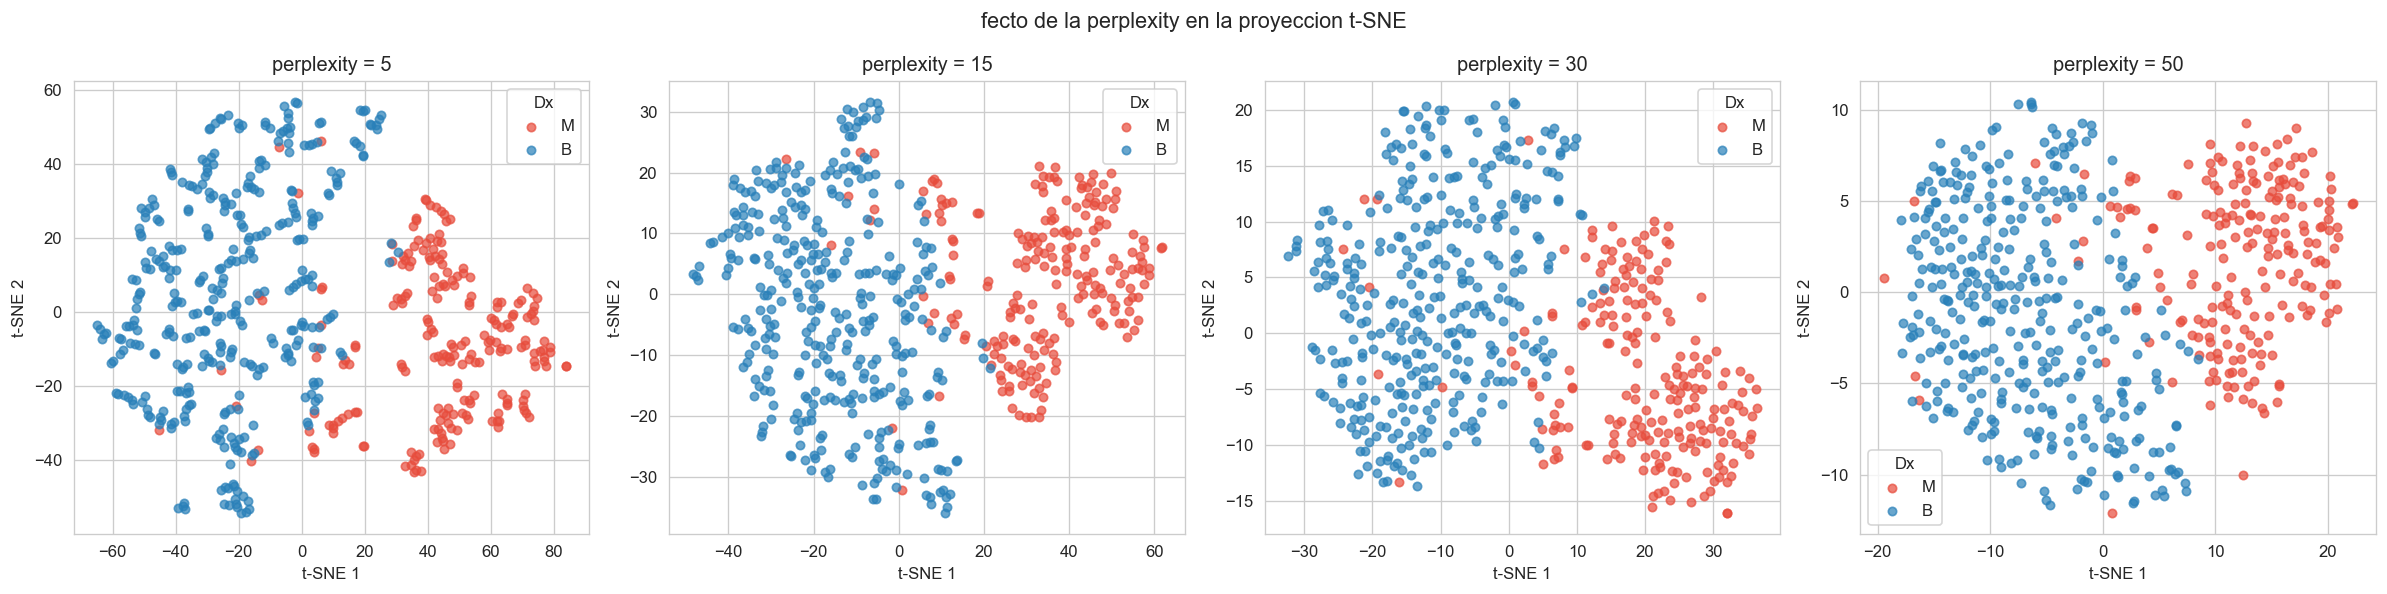

In [17]:
# perplexity controla el balance entre estructura local y global. Aproximadamente indica cuántos vecinos considera el algoritmo por punto.
perplexities = [5, 15, 30, 50]
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, perp in zip(axes, perplexities):
    tsne_tmp = TSNE(n_components=2, perplexity=perp,
                    max_iter=1000, random_state=42, init='pca')
    emb = tsne_tmp.fit_transform(X_scaled)
    for diag, color in [('M', '#e74c3c'), ('B', '#2980b9')]:
        mask_d = y == diag
        ax.scatter(emb[mask_d, 0], emb[mask_d, 1],
                   color=color, alpha=0.7, s=25, label=diag)
    ax.set_title(f'perplexity = {perp}')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.legend(title='Dx')

plt.suptitle('fecto de la perplexity en la proyeccion t-SNE', fontsize=13)
plt.tight_layout()
plt.show()

In [18]:
# Seleccionamos perplexity=30  con max_iter=2000 para garantizar convergencia.
tsne = TSNE(
    n_components=2,
    perplexity=30,
    max_iter=2000,
    learning_rate='auto',
    init='pca',
    random_state=42
)
X_tsne = tsne.fit_transform(X_scaled)

print(f'Shape de la proyeccion t-SNE: {X_tsne.shape}')
print(f'KL Divergence final (menor es mejor): {tsne.kl_divergence_:.4f}')

Shape de la proyeccion t-SNE: (569, 2)
KL Divergence final (menor es mejor): 0.9398


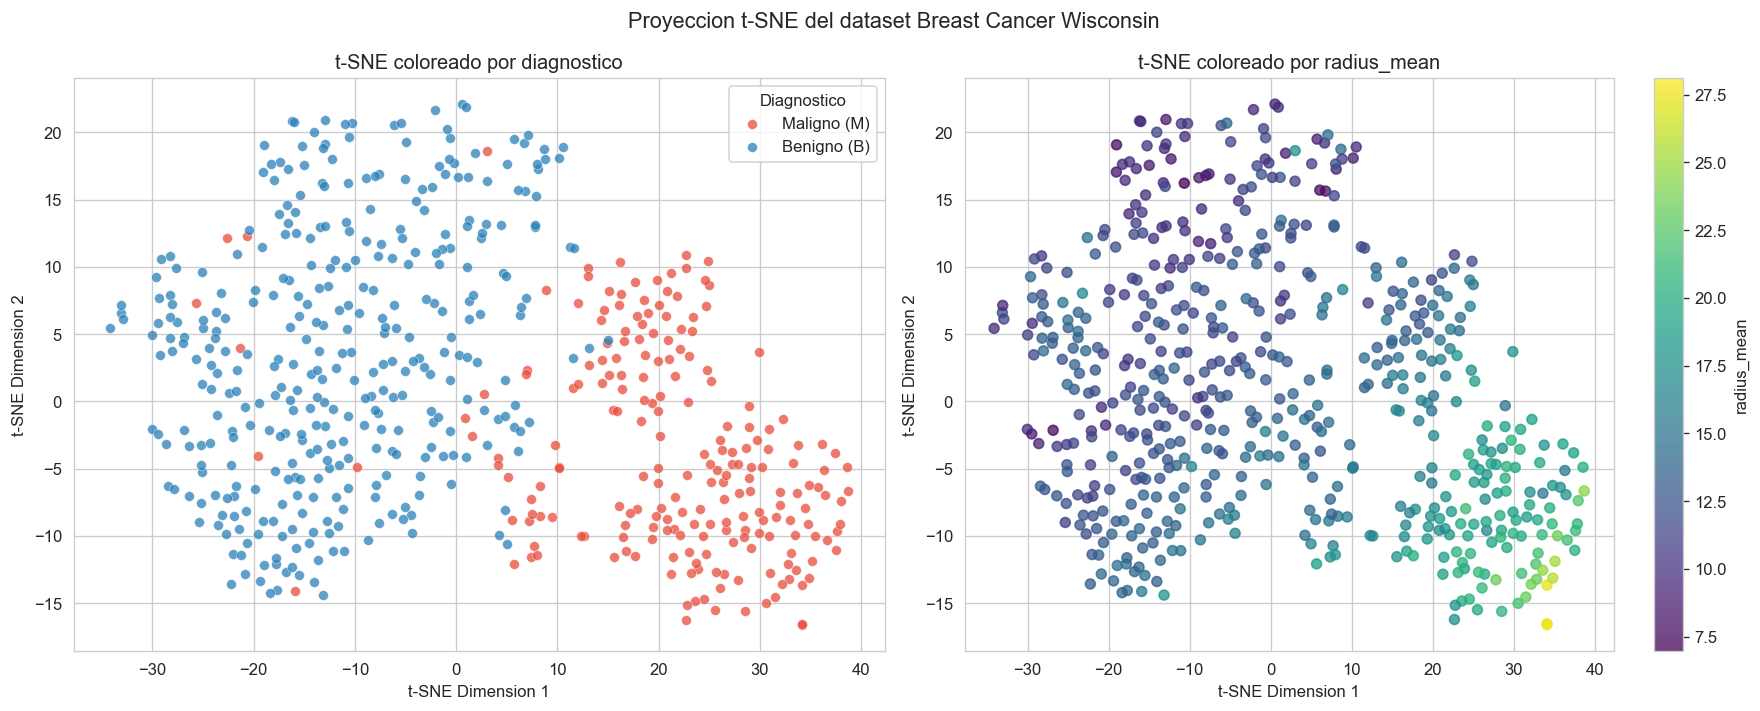

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Izquierda: coloreado por diagnostico
for diag, color, label in [('M', '#e74c3c', 'Maligno (M)'), ('B', '#2980b9', 'Benigno (B)')]:
    mask_d = y == diag
    axes[0].scatter(X_tsne[mask_d, 0], X_tsne[mask_d, 1],
                    color=color, alpha=0.75, s=35, label=label,
                    edgecolors='white', linewidths=0.3)
axes[0].set_title('t-SNE coloreado por diagnostico', fontsize=12)
axes[0].set_xlabel('t-SNE Dimension 1')
axes[0].set_ylabel('t-SNE Dimension 2')
axes[0].legend(title='Diagnostico')

# Derecha: coloreado por radius_mean (feature continua)
sc = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1],
                     c=bc['radius_mean'], cmap='viridis', alpha=0.75, s=35)
plt.colorbar(sc, ax=axes[1], label='radius_mean')
axes[1].set_title('t-SNE coloreado por radius_mean', fontsize=12)
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')

plt.suptitle('Proyeccion t-SNE del dataset Breast Cancer Wisconsin', fontsize=13)
plt.tight_layout()
plt.show()

## Estadísticas por Grupo en el Espacio t-SNE

In [20]:
# Tabla de medias por diagnostico
print('Media de features clave por diagnostico')
resumen = bc.groupby('diagnosis')[['radius_mean', 'texture_mean',
                                     'concavity_mean', 'area_worst']].mean().round(3)
print(resumen.to_string())

# Distribucion por cuadrante en el espacio t-SNE
print('\nDistribucion de diagnosticos por cuadrante t-SNE')
tsne_df = pd.DataFrame({'tsne1': X_tsne[:, 0], 'tsne2': X_tsne[:, 1], 'diagnosis': y.values})
tsne_df['cuadrante'] = tsne_df.apply(
    lambda r: f"({'sup' if r['tsne2'] > 0 else 'inf'}-{'der' if r['tsne1'] > 0 else 'izq'})", axis=1
)
print(tsne_df.groupby(['cuadrante', 'diagnosis']).size().unstack(fill_value=0))

Media de features clave por diagnostico
           radius_mean  texture_mean  concavity_mean  area_worst
diagnosis                                                       
B               12.147        17.915           0.046     558.899
M               17.463        21.605           0.161    1422.286

Distribucion de diagnosticos por cuadrante t-SNE
diagnosis    B    M
cuadrante          
(inf-der)   13  144
(inf-izq)  124    3
(sup-der)   47   61
(sup-izq)  173    4


## Interpretación de Resultados — t-SNE

**Separacion de clases:** La proyeccion t-SNE muestra una separacion clara entre tumores malignos y benignos. Los malignos forman un cluster compacto y diferenciado de los benignos, con una zona de traslape minoritaria que representa los casos clinicamente mas ambiguos.

**Comparacion con PCA:** PCA separa los grupos de forma lineal pero con mayor solapamiento. t-SNE revela una estructura mas compacta porque captura relaciones no lineales entre las 30 features.

**Efecto de perplexity:** Con perplexity baja (5), los clusters se fragmentan en subclusters muy pequeños. Con perplexity alta (50), la estructura se difumina. perplexity=30 ofrece el mejor equilibrio.

**KL Divergence:** Mide que tan bien la distribucion 2D preserva la original de 30D. Un valor menor indica una proyeccion mas fiel.

**Limitaciones:** t-SNE no preserva distancias globales (la distancia entre clusters no es interpretable), su complejidad computacional es O(n^2), y los resultados varian con la semilla aleatoria.